In [2]:
import numpy as np
import pandas as pd 
from sklearn.linear_model import LinearRegression
import inventorize as inv 

In [3]:
price = [5,10,15,17,20,23,25]
demand = [600, 550, 700, 680, 500, 400, 250]

In [5]:
pricing_data = pd.DataFrame({
    'price': price,
    'demand': demand
})

In [6]:
pricing_data

,price,demand
0,5,600
1,10,550
2,15,700
3,17,680
4,20,500
5,23,400
6,25,250


In [7]:
model = LinearRegression()

In [9]:
model.fit(pricing_data[['price']],
pricing_data[['demand']])

LinearRegression()

In [10]:
model.intercept_

array([766.26999059])

In [12]:
model.coef_

array([[-14.64252117]])

In [20]:
guava_cost = 2.5

In [14]:
simulation_data = pd.DataFrame({
    'price': range(1,50)
})

In [16]:
model.intercept_[0]

766.2699905926621

In [18]:
simulation_data['expected_demand'] = model.intercept_[0] + model.coef_[0]* simulation_data['price']

In [21]:
simulation_data['total_cost'] = simulation_data['expected_demand'] * guava_cost

In [23]:
simulation_data['revenue'] = simulation_data['expected_demand'] * simulation_data['price']

In [24]:
simulation_data['profit'] = simulation_data['revenue'] - simulation_data['total_cost']

In [25]:
simulation_data[simulation_data.profit == max(simulation_data.profit)]

,price,expected_demand,total_cost,revenue,profit
26,27,370.921919,927.304798,10014.891816,9087.587018


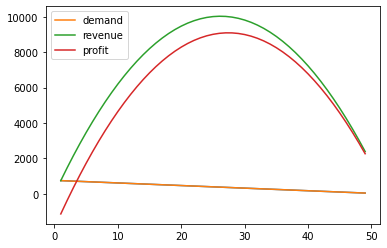

In [27]:
import matplotlib.pyplot as plt
plt.plot(simulation_data.price,simulation_data.expected_demand)
plt.plot(simulation_data.price,simulation_data.expected_demand,label='demand')
plt.plot(simulation_data.price,simulation_data.revenue,label='revenue')
plt.plot(simulation_data.price,simulation_data.profit,label='profit')
plt.legend(loc='upper left')

In [28]:
pricing_data

,price,demand
0,5,600
1,10,550
2,15,700
3,17,680
4,20,500
5,23,400
6,25,250


In [29]:
inv.linear_elasticity(
    pricing_data['price'],
    pricing_data['demand'],
    23, 2.5
)

{'Elasticity': array([[0.78413098]]),
 'optimum_price_profit': array([[27.41591712]]),
 'optimum_price_revenue': array([[26.16591712]])}

In [31]:
import os 
path = os.getcwd()
print(path)

/Users/dang/Desktop/Learning/Mygit/datascience_supplychain_practice/Jupyternotebook_source/Section_19_Consumer_behavior_and_pricing


In [32]:
retail_clean = pd.read_csv('{0}/retail_clean.csv'.format(path))

In [33]:
retail_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779495 entries, 0 to 779494
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   779495 non-null  int64  
 1   Invoice      779495 non-null  int64  
 2   StockCode    779495 non-null  object 
 3   Description  779495 non-null  object 
 4   Quantity     779495 non-null  int64  
 5   InvoiceDate  779495 non-null  object 
 6   Price        779495 non-null  float64
 7   Customer ID  779495 non-null  float64
 8   Country      779495 non-null  object 
 9   Revenue      779495 non-null  float64
dtypes: float64(3), int64(3), object(4)
memory usage: 59.5+ MB


In [34]:
retail_clean['InvoiceDate'] = pd.to_datetime(retail_clean['InvoiceDate'])

In [35]:
retail_clean['year'] = retail_clean['InvoiceDate'].dt.year

In [36]:
retail_clean['week'] = retail_clean['InvoiceDate'].dt.week

ipykernel_launcher:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [37]:
retail_clean['weekyear'] = retail_clean['InvoiceDate'].dt.strftime('%W %Y')

In [38]:
retail_clean.head()

,Unnamed: 0,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Revenue,year,week,weekyear
0,0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2009,49,48 2009
1,1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009,49,48 2009
2,2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009,49,48 2009
3,3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,2009,49,48 2009
4,4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,2009,49,48 2009


In [39]:
weekly_sales = retail_clean.groupby(['Description', 'weekyear']).agg(
    total_sales = ('Quantity', 'sum'),
    price = ('Price', 'mean')).reset_index()

In [40]:
keys = weekly_sales.Description.unique()

In [41]:
keys

array(['  DOORMAT UNION JACK GUNS AND ROSES', ' 3 STRIPEY MICE FELTCRAFT',
       ' 4 PURPLE FLOCK DINNER CANDLES', ...,
       'ZINC WILLIE WINKIE  CANDLE STICK', 'ZINC WIRE KITCHEN ORGANISER',
       'ZINC WIRE SWEETHEART LETTER TRAY'], dtype=object)

In [42]:
len(keys)

5283

In [43]:
empty_data = pd.DataFrame()

In [45]:
for key in keys:
    try:
        a = weekly_sales[weekly_sales.Description == key]
        cost = 0.4 * max(a['price'])
        current_price = a['price'].mean()
        elasticity = inv.linear_elasticity(
            a['price'], a['total_sales'],
            current_price, cost
        )
        elasticity = {k:v[0] for k,v in elasticity.items()}
        data = pd.DataFrame(elasticity, index = [0])
        data['Description'] = key
        empty_data = pd.concat([empty_data, data], axis=0)
    except:
        continue

t=(-derv_p*cost_of_product+ intercept)/(2*-derv_p)
/Users/dang/Desktop/Learning/Mygit/datascience_supplychain_practice/env/lib/python3.7/site-packages/inventorize/__init__.py:663: RuntimeWarning: divide by zero encountered in true_divide
  optimum_revenue =intercept/(2*-derv_p)
/Users/dang/Desktop/Learning/Mygit/datascience_supplychain_practice/env/lib/python3.7/site-packages/inventorize/__init__.py:662: RuntimeWarning: divide by zero encountered in true_divide
  optimum_profit=(-derv_p*cost_of_product+ intercept)/(2*-derv_p)
/Users/dang/Desktop/Learning/Mygit/datascience_supplychain_practice/env/lib/python3.7/site-packages/inventorize/__init__.py:663: RuntimeWarning: divide by zero encountered in true_divide
  optimum_revenue =intercept/(2*-derv_p)
/Users/dang/Desktop/Learning/Mygit/datascience_supplychain_practice/env/lib/python3.7/site-packages/inventorize/__init__.py:662: RuntimeWarning: divide by zero encountered in true_divide
  optimum_profit=(-derv_p*cost_of_product+ intercept)

In [47]:
empty_data.iloc[2,:]

Elasticity                       2.317158
optimum_price_profit             4.362780
optimum_price_revenue            3.372780
Description               FLAMINGO LIGHTS
Name: 0, dtype: object

In [48]:
price = [5,10,15,17,20,23,25]
demand = [600, 550, 700, 680, 500, 400, 250]

In [49]:
pricing_data = pd.DataFrame({
    'price': price,
    'demand': demand
})

In [51]:
pricing_data

,price,demand
0,5,600
1,10,550
2,15,700
3,17,680
4,20,500
5,23,400
6,25,250


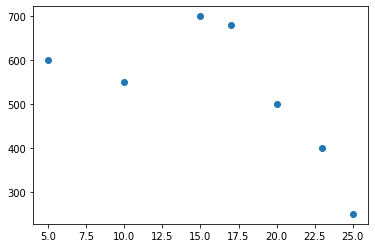

In [52]:
plt.scatter(price, demand)

In [53]:
logit_linear = inv.single_product_optimization(price, demand, 'Mango', 20, 4)

/Users/dang/Desktop/Learning/Mygit/datascience_supplychain_practice/env/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [54]:
logit_linear

{'optimization_paremeters':  final_simplex: (array([[-4.76292472e+00,  2.29095916e-01,  5.07841645e+02],
        [-4.76292471e+00,  2.29095915e-01,  5.07841645e+02],
        [-4.76292466e+00,  2.29095913e-01,  5.07841645e+02],
        [-4.76292469e+00,  2.29095914e-01,  5.07841645e+02]]), array([10993.65115399, 10993.65115399, 10993.65115399, 10993.65115399]))
            fun: 10993.651153985002
        message: 'Optimization terminated successfully.'
           nfev: 267
            nit: 149
         status: 0
        success: True
              x: array([-4.76292472e+00,  2.29095916e-01,  5.07841645e+02]),
 'lm_model': LinearRegression(),
 'squared_error_logit': 'squared_error_logit= 10993.651153985002',
 'squared_error_linear': 'squared_errorr_lm= 87654.04515522107',
 'simulation_data':             x  predicted_linear  predicted_logit  revenue_linear  \
 0   -7.806472        880.576416       512.608727    -6874.194763   
 1   -6.806472        865.933895       513.630096    -5893.954

In [56]:
type(logit_linear)
logit_linear.keys()

dict_keys(['optimization_paremeters', 'lm_model', 'squared_error_logit', 'squared_error_linear', 'simulation_data', 'best_model', 'optimum_linear', 'optimum_logit', 'current_price', 'article_name', 'predictions', 'point_of_maximum_profits'])

In [57]:
prediction_Data = logit_linear['predictions']

In [58]:
prediction_Data

,x,y,lm_p,logit_p
0,5,600,693.057385,558.225194
1,10,550,619.844779,615.604567
2,15,700,546.632173,670.744617
3,17,680,517.347131,656.449371
4,20,500,473.419567,551.424175
5,23,400,429.492004,370.288847
6,25,250,400.206961,252.617168


{'linear': array([28.19352842]), 'logit': array([19.19352842])}

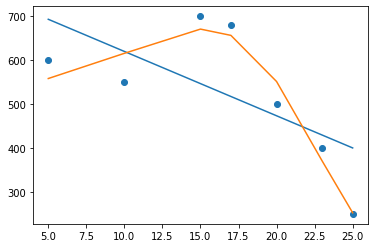

In [60]:
plt.scatter(prediction_Data.x, prediction_Data.y)
plt.plot(prediction_Data.x, prediction_Data.lm_p)
plt.plot(prediction_Data.x,prediction_Data.logit_p)

logit_linear['point_of_maximum_profits']